In [1]:
import numpy as np
import os
import torch
import torch.optim as optim
import torch.nn as nn

from torch.autograd import Variable
from torch.utils.data import DataLoader

from DNN_model import DNN
from load_data import DatasetFromHdf5
from utils import ts_to_np,np_to_ts,batch_psnr,plot_loss_save,plot_loss

check if GPU can be used

In [2]:
GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


Parameters setting

In [3]:
batchSize=20
num_images=5000
epochs=200
image_size=32
print_every=50
lr=0.001
model_path='./model_dir'
iters=[]
y_loss=[]

Load training dataseta and testing dataset

In [4]:
train_set = DatasetFromHdf5("./dataset/train_mnist.h5")
test_set = DatasetFromHdf5("./dataset/test_mnist.h5")
training_data_loader = DataLoader(dataset=train_set,batch_size=batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set,batch_size=batchSize, shuffle=True)

D:\pengyang\pytorch\DLGI\DNN\load_data.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File(file_path)


Initialize the model and define the optimizer

In [5]:
model=DNN()
criterion=nn.MSELoss()
if torch.cuda.is_available:
    model.cuda()
    criterion.cuda()
    
optimizer=optim.Adam(model.parameters(),lr=lr)
device=torch.device('cuda:0' if GPU else 'cpu')

Training process

In [6]:
for epoch in range(1, epochs+1):
    #milestone
    if epoch>800:
        current_lr=lr/100.
    elif epoch>500:
        current_lr=lr/10.
    else:
        current_lr=lr
    
    for i, batch in enumerate(training_data_loader,1):
        model.train()
        model.zero_grad()
        optimizer.zero_grad()
        
        #obtain a batch of data and label
        data, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
        data=data.cuda()
        target = target.cuda()
        
        #input the data to the DNN
        out=model(data)
        
        #calculate the loss between the network output and label using MSE function
        loss=criterion(out,target)/(batchSize*2)
        
        loss.backward()
        optimizer.step()
           
        model.eval()
        
        #show the PSNR of the training data until now
        if i % print_every == 0:
            out_np=ts_to_np(out)
            target_np=ts_to_np(target)
    
            psnr_train=batch_psnr(out_np,target_np)
            print("[epoch %d][%d/%d] loss: %.10f PSNR_train: %.4f" % (epoch, i,len(training_data_loader), loss.item(), psnr_train))
    
    #save the loss value at this epoch    
    plot_loss_save(epoch,iters,y_loss,loss)       
    
        
    #verify the model efficiency with the trained model   
    model.eval() 
    psnr_test=0
    for i, batch in enumerate(testing_data_loader):
        data, target = Variable(batch[0]),Variable(batch[1], requires_grad=False)
        
        out_test=model(data.cuda())
        #print(out_val.shape)
        out_test_np=ts_to_np(out_test)
       
        target_np=ts_to_np(target)
      
        psnr_test+=batch_psnr(out_test_np,target_np)
        
            
    psnr_test /= len(testing_data_loader)
    print("\n[epoch %d] PSNR_test: %.4f" % (epoch, psnr_test))

torch.save(model.state_dict(), os.path.join(model_path, 'DNN_{}.pth'.format(epoch)))

[epoch 1][50/250] loss: 0.0008816830 PSNR_train: 15.1363
[epoch 1][100/250] loss: 0.0006988191 PSNR_train: 15.8961
[epoch 1][150/250] loss: 0.0007468682 PSNR_train: 15.5505
[epoch 1][200/250] loss: 0.0005560445 PSNR_train: 17.1396
[epoch 1][250/250] loss: 0.0004982674 PSNR_train: 17.5905

[epoch 1] PSNR_test: 17.2264
[epoch 2][50/250] loss: 0.0005725230 PSNR_train: 16.9316
[epoch 2][100/250] loss: 0.0005392987 PSNR_train: 17.2430
[epoch 2][150/250] loss: 0.0004598863 PSNR_train: 17.7920
[epoch 2][200/250] loss: 0.0004094410 PSNR_train: 18.3712
[epoch 2][250/250] loss: 0.0004949056 PSNR_train: 17.5647

[epoch 2] PSNR_test: 18.5461
[epoch 3][50/250] loss: 0.0004044814 PSNR_train: 18.4869
[epoch 3][100/250] loss: 0.0004208046 PSNR_train: 18.3301
[epoch 3][150/250] loss: 0.0003975333 PSNR_train: 18.5302
[epoch 3][200/250] loss: 0.0004190478 PSNR_train: 18.3241
[epoch 3][250/250] loss: 0.0004479412 PSNR_train: 17.7706

[epoch 3] PSNR_test: 19.4910
[epoch 4][50/250] loss: 0.0003914166 PSNR_t

[epoch 26][200/250] loss: 0.0002103954 PSNR_train: 20.9953
[epoch 26][250/250] loss: 0.0002094277 PSNR_train: 21.1890

[epoch 26] PSNR_test: 21.5788
[epoch 27][50/250] loss: 0.0002012233 PSNR_train: 21.3043
[epoch 27][100/250] loss: 0.0001917110 PSNR_train: 21.4843
[epoch 27][150/250] loss: 0.0002323904 PSNR_train: 20.6185
[epoch 27][200/250] loss: 0.0002064077 PSNR_train: 21.0690
[epoch 27][250/250] loss: 0.0001977719 PSNR_train: 21.2180

[epoch 27] PSNR_test: 22.2661
[epoch 28][50/250] loss: 0.0002580948 PSNR_train: 20.0638
[epoch 28][100/250] loss: 0.0002495193 PSNR_train: 20.3754
[epoch 28][150/250] loss: 0.0002175129 PSNR_train: 20.9248
[epoch 28][200/250] loss: 0.0002613773 PSNR_train: 20.2698
[epoch 28][250/250] loss: 0.0001892602 PSNR_train: 21.6980

[epoch 28] PSNR_test: 22.0716
[epoch 29][50/250] loss: 0.0002063461 PSNR_train: 21.0736
[epoch 29][100/250] loss: 0.0001802993 PSNR_train: 21.6132
[epoch 29][150/250] loss: 0.0001884717 PSNR_train: 21.6143
[epoch 29][200/250] loss:

[epoch 52][50/250] loss: 0.0001991806 PSNR_train: 21.1078
[epoch 52][100/250] loss: 0.0001817928 PSNR_train: 21.6490
[epoch 52][150/250] loss: 0.0001998963 PSNR_train: 21.2137
[epoch 52][200/250] loss: 0.0001509515 PSNR_train: 22.4833
[epoch 52][250/250] loss: 0.0001670095 PSNR_train: 22.0297

[epoch 52] PSNR_test: 22.7566
[epoch 53][50/250] loss: 0.0001801014 PSNR_train: 21.6372
[epoch 53][100/250] loss: 0.0001651995 PSNR_train: 22.1084
[epoch 53][150/250] loss: 0.0001709651 PSNR_train: 21.9645
[epoch 53][200/250] loss: 0.0001797759 PSNR_train: 21.7825
[epoch 53][250/250] loss: 0.0001698068 PSNR_train: 21.9751

[epoch 53] PSNR_test: 22.7984
[epoch 54][50/250] loss: 0.0001606861 PSNR_train: 22.0840
[epoch 54][100/250] loss: 0.0001799869 PSNR_train: 21.6274
[epoch 54][150/250] loss: 0.0001523556 PSNR_train: 22.2828
[epoch 54][200/250] loss: 0.0001978171 PSNR_train: 21.2669
[epoch 54][250/250] loss: 0.0002077367 PSNR_train: 20.9062

[epoch 54] PSNR_test: 22.5233
[epoch 55][50/250] loss: 

[epoch 77][150/250] loss: 0.0001297373 PSNR_train: 23.1755
[epoch 77][200/250] loss: 0.0001558959 PSNR_train: 22.1961
[epoch 77][250/250] loss: 0.0001445236 PSNR_train: 22.6382

[epoch 77] PSNR_test: 22.9566
[epoch 78][50/250] loss: 0.0001724418 PSNR_train: 21.8107
[epoch 78][100/250] loss: 0.0001695509 PSNR_train: 21.9744
[epoch 78][150/250] loss: 0.0001486187 PSNR_train: 22.4277
[epoch 78][200/250] loss: 0.0001899700 PSNR_train: 21.3434
[epoch 78][250/250] loss: 0.0001462560 PSNR_train: 22.5754

[epoch 78] PSNR_test: 22.9982
[epoch 79][50/250] loss: 0.0001474253 PSNR_train: 22.5265
[epoch 79][100/250] loss: 0.0001646700 PSNR_train: 22.0182
[epoch 79][150/250] loss: 0.0001671248 PSNR_train: 21.8878
[epoch 79][200/250] loss: 0.0001519933 PSNR_train: 22.3201
[epoch 79][250/250] loss: 0.0001615682 PSNR_train: 22.2507

[epoch 79] PSNR_test: 23.0162
[epoch 80][50/250] loss: 0.0001576177 PSNR_train: 22.3019
[epoch 80][100/250] loss: 0.0001722443 PSNR_train: 21.7175
[epoch 80][150/250] loss:

[epoch 102][200/250] loss: 0.0001597679 PSNR_train: 22.1980
[epoch 102][250/250] loss: 0.0001816388 PSNR_train: 21.4686

[epoch 102] PSNR_test: 23.0914
[epoch 103][50/250] loss: 0.0001556663 PSNR_train: 22.2460
[epoch 103][100/250] loss: 0.0001491280 PSNR_train: 22.4113
[epoch 103][150/250] loss: 0.0001876718 PSNR_train: 21.3976
[epoch 103][200/250] loss: 0.0001358121 PSNR_train: 22.8808
[epoch 103][250/250] loss: 0.0001745973 PSNR_train: 21.7455

[epoch 103] PSNR_test: 23.0935
[epoch 104][50/250] loss: 0.0001596149 PSNR_train: 22.3866
[epoch 104][100/250] loss: 0.0001359009 PSNR_train: 22.7693
[epoch 104][150/250] loss: 0.0001380209 PSNR_train: 22.7314
[epoch 104][200/250] loss: 0.0001370608 PSNR_train: 22.8633
[epoch 104][250/250] loss: 0.0002043283 PSNR_train: 21.0540

[epoch 104] PSNR_test: 22.9500
[epoch 105][50/250] loss: 0.0001616325 PSNR_train: 22.0894
[epoch 105][100/250] loss: 0.0001365851 PSNR_train: 22.8606
[epoch 105][150/250] loss: 0.0001590155 PSNR_train: 22.2737
[epoch 

[epoch 127][150/250] loss: 0.0001418703 PSNR_train: 22.7764
[epoch 127][200/250] loss: 0.0001332929 PSNR_train: 23.0304
[epoch 127][250/250] loss: 0.0001309990 PSNR_train: 22.9636

[epoch 127] PSNR_test: 23.0730
[epoch 128][50/250] loss: 0.0001497884 PSNR_train: 22.4962
[epoch 128][100/250] loss: 0.0001364365 PSNR_train: 22.9790
[epoch 128][150/250] loss: 0.0001571824 PSNR_train: 22.2512
[epoch 128][200/250] loss: 0.0001402506 PSNR_train: 22.7315
[epoch 128][250/250] loss: 0.0001519220 PSNR_train: 22.3190

[epoch 128] PSNR_test: 23.1900
[epoch 129][50/250] loss: 0.0001219409 PSNR_train: 23.3566
[epoch 129][100/250] loss: 0.0001217583 PSNR_train: 23.2289
[epoch 129][150/250] loss: 0.0001279634 PSNR_train: 23.1091
[epoch 129][200/250] loss: 0.0001495192 PSNR_train: 22.3721
[epoch 129][250/250] loss: 0.0001591810 PSNR_train: 22.1454

[epoch 129] PSNR_test: 23.2479
[epoch 130][50/250] loss: 0.0001387467 PSNR_train: 22.7330
[epoch 130][100/250] loss: 0.0001378366 PSNR_train: 22.9568
[epoch 

[epoch 152][100/250] loss: 0.0001272454 PSNR_train: 23.1815
[epoch 152][150/250] loss: 0.0001388557 PSNR_train: 22.7079
[epoch 152][200/250] loss: 0.0001375807 PSNR_train: 22.7761
[epoch 152][250/250] loss: 0.0001252633 PSNR_train: 23.1708

[epoch 152] PSNR_test: 23.3798
[epoch 153][50/250] loss: 0.0001642604 PSNR_train: 22.1460
[epoch 153][100/250] loss: 0.0001247005 PSNR_train: 23.2556
[epoch 153][150/250] loss: 0.0001633314 PSNR_train: 21.9828
[epoch 153][200/250] loss: 0.0001312984 PSNR_train: 22.9558
[epoch 153][250/250] loss: 0.0001455034 PSNR_train: 22.5933

[epoch 153] PSNR_test: 23.3962
[epoch 154][50/250] loss: 0.0001295187 PSNR_train: 23.0392
[epoch 154][100/250] loss: 0.0001422016 PSNR_train: 22.7167
[epoch 154][150/250] loss: 0.0001261383 PSNR_train: 23.1882
[epoch 154][200/250] loss: 0.0001402262 PSNR_train: 22.6974
[epoch 154][250/250] loss: 0.0001487049 PSNR_train: 22.4711

[epoch 154] PSNR_test: 23.3536
[epoch 155][50/250] loss: 0.0001285232 PSNR_train: 23.1129
[epoch 

[epoch 177][50/250] loss: 0.0001322693 PSNR_train: 22.8927
[epoch 177][100/250] loss: 0.0001674364 PSNR_train: 21.9518
[epoch 177][150/250] loss: 0.0001595062 PSNR_train: 22.0564
[epoch 177][200/250] loss: 0.0001321060 PSNR_train: 22.9647
[epoch 177][250/250] loss: 0.0001139818 PSNR_train: 23.6756

[epoch 177] PSNR_test: 23.4213
[epoch 178][50/250] loss: 0.0001732691 PSNR_train: 21.7234
[epoch 178][100/250] loss: 0.0001609416 PSNR_train: 22.0392
[epoch 178][150/250] loss: 0.0001816864 PSNR_train: 21.5513
[epoch 178][200/250] loss: 0.0001487689 PSNR_train: 22.4284
[epoch 178][250/250] loss: 0.0001378511 PSNR_train: 22.7053

[epoch 178] PSNR_test: 23.3523
[epoch 179][50/250] loss: 0.0001309167 PSNR_train: 22.9822
[epoch 179][100/250] loss: 0.0001506366 PSNR_train: 22.4534
[epoch 179][150/250] loss: 0.0001180200 PSNR_train: 23.5237
[epoch 179][200/250] loss: 0.0001113166 PSNR_train: 23.7576
[epoch 179][250/250] loss: 0.0001272804 PSNR_train: 23.0827

[epoch 179] PSNR_test: 23.4435
[epoch 

Plot the training loss

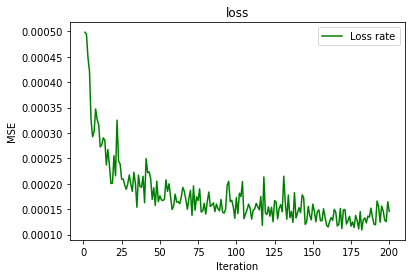

In [7]:
plot_loss(iters,y_loss)